# FEXI notebook

### Imports

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
from scipy.special import erf
import scipy.stats

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.core.modeling_framework import MultiCompartmentSphericalMeanModel
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

from scipy.io import savemat

### FEXI simulations
#### Simulated $s$ signal axr_sim()

In [33]:
def axr_sim(adc, sigma, axr, bf, be, tm):
   """Generate an output signal s based on known inputs for a given voxel
Inputs   - adc:      apparent diffusion coefficient [m2/s] single value
         - sigma:    filter efficiency single value
         - axr:      exchange rate [1/s] single value
         - bf:       filter block b-value [m2/s] 20x1
         - be:       encoding block b-value [m2/s] 20x1
         - tm:       mixing time [s] 20x1

Output: 	- s:        signal (sum of the magnetisations) single value
   Based off Elizabeth's code. 
   """

   tm[(bf == 0) & (tm == min(tm))] = np.inf
   #calculate ADC as fnc of mixing time
   adc_tm = adc * (1 - sigma* np.exp(-axr*tm))

   # compute signal
   s = np.exp(-adc_tm*be)
   return s 


### Estimate $ADC$, $\sigma$ & $AXR$
#### fit_axr_sse()

In [34]:
#==========================================================================
# Calculate sum of square error between mixing time estimate vs adc and true value. 
# Inputs    - free_params:  parameter values being fitted
#                           [adc sigma axr] 
#           - scheme:       acquisition parameters [nx3]
#                           [bf, be, tm]
#           - all_params:   array of all parameters
#                           [adc sigma axr] 
#           - idx_free:     indices of free parameters within free_params
#           - idx_adc:      indices into scheme of acquisitions used for ADC calc
#           - idx_s0sf:     indices into scheme of acquisitions used for S0/Sf calc
#                       - NORMALISED to b=0 for each bf, tm combination so that S0 = Sbf = 0
#           
# Outputs   - sfit:     fitted signal [1, ntm x nbval]
#
def fit_axr_sse(free_params, all_params, idx_free, bf, tm, be, smeas):
    
	# extract dependent variables
    #first row only
    all_params = all_params[1]
    # set param to free value where index say to do so
    #all_params[idx_free] = free_params
    all_params = free_params

    adc = all_params[0]
    sigma = all_params[1]
    axr = all_params[2]

    # calculate ADC'(tm) from measured data

    # using bf and tm as column vectors and as first 2 columns, see how 
    # many rows they contain
    # size(unique(...),1) takes num of rows.
    # unique() keeps only unique combinations.
    nsf = np.unique(np.column_stack((bf.flatten(), tm.flatten())), axis=0).shape[0]
    # number of unique bf,tm combos
    
    #stable keeps order it was put in (with duplicates removed)
    univols = np.unique(np.column_stack((bf.flatten(), tm.flatten())), axis=0)
    # find the pairs of data points used to calculate each ADC'(tm)
    
    #same length as bf and tm
    adc_tm_calc = np.zeros((1, nsf))

    # [bf,tm] has some duplicate rows
    # univols is [bf,tm] without duplicates

    for v in range(0, nsf):
        # change way it loops

        #ix1 is an index 
        # when b value is zero and where both values in row v of univols
        # are the same as the values in [bf,tm]
        # what is the physical meaning of this?

        ix1 = np.where((np.sum(univols[v - 1] == np.concatenate((bf, tm)), axis=1) == 2) & (be == 0))[0]
        # when b value is none zero and where both values in row v of univols
        # are the same as the values in [bf,tm]
        # what is the physical meaning of this?
        
        ix2 = np.where((np.sum(univols[v - 1] == np.concatenate((bf, tm)), axis=1) == 2) & (be > 0))[0]

        #smeas is normalised signal
        #calculate the adc value and make it row v of adc_tm_calc
        # see eq 7 of https://doi.org/10.1016/j.neuroimage.2020.117039
        adc_tm_calc[v] = -1 / (be[ix2] - be[ix1]) * np.log(smeas[ix2] / smeas[ix1])

    # find equilibrium acquisition (bf==0, tm==min(tm)), and set tm=inf for this
    
    # create an index of when bf is 0, and tm is minimum
    idx_eq = np.where((univols[:, 0] == 0) & (univols[:, 1] == np.min(univols[:, 1])))[0]
    # equilibrium scans without filter

    tm = univols[:,1]
    #changed the index
    #set the tm to infinity where condition was met
    #why?
    tm[idx_eq] = np.inf
    
    # estimate ADC'(tm) by fitting model
    # eq 2 from https://doi.org/10.1016/j.neuroimage.2020.117039
    adc_tm_fit = adc * (1 - sigma * np.exp(-tm*axr))
    
    # sum of squares difference
    sse = np.sum((adc_tm_calc[:] - adc_tm_fit[:])**2)

    return sse




#### axr_fit()

In [35]:
#==========================================================================
# for a given signal estimate the variables that produced it. 
# Estimate adc, sigma and axr
#  (Lasic 2011, MRM)
#
# Use: adc, sigma, axr = axr_fit(bf, be, tm, smeas, init, lb, ub)
#
# Inputs    - bf:       filter block b-value [m^2/s] 20x1
#           - be:       encoding block b-value [m^2/s] 20x1 
#           - tm:       mixing time [s] 20x1 
#           - smeas:    measured signal (normalised) 20x1
#           - init:     initial values  [adc, sigma, axr] [m2/s a.u. 1/s] 3x1
#           - lb:       lower bounds   [adc, sigma, axr] [m2/s a.u. 1/s] 3x1
#           - ub:       upper bounds   [adc, sigma, axr] [m2/s a.u. 1/s] 3x1
#
# Output: 	- adc:      fitted ADC [m2/s] single value
#           - sigma:	fitted filter efficiency single value 
#           - axr:      fitted AXR [1/s] single value
#
# Adapted from Author: E Powell, 23/08/23
#
#==========================================================================

def axr_fit(bf, be, tm, s, init, lb, ub):

    # use parpool if rows in init >= 25 goes here
    # Compare to matlab code. 

    #scaling bf and be
    # need to be ~1, not sure why
    bf = bf * 1e-9
    be = be * 1e-9

    all_params = init 
    all_params[0] = all_params[0] * 1e9 
    # copy init into all_params and multiply first value by 1e9. 

    # multiply first value by 1e9
    lb[0] = lb[0] * 1e9
    ub[0] = ub[0] * 1e9

    #store indices where lb != ub and ==
    idx_free = np.nonzero(lb != ub)[0]
    idx_fixed = np.nonzero(lb == ub)[0]

    # select initial values and bounds only for free params
    free_params = all_params[idx_free]

    #old method not working
    #free_params = all_params[:,idx_free]
    
    lb = lb[idx_free]
    ub = ub[idx_free]
    
    #hide output during iterations. Not sure what purpose is or what is
    #python equivalent
    #opt = optimset('display', 'off'); 

    fitting = lambda free_params: fit_axr_sse(free_params, all_params, idx_free, bf, tm, be, s)

    # 2 versions of code using parpool in matlab version

    for i in range(np.size(init)):
        res= scipy.optimize.minimize(fun=fitting, x0=free_params)
        xopt, fval, ierr, numfunc = res
        #xopt, fval = scipy.optimize.fminbound(func=fitting, args=(free_params[i],), x1 = lb, x2 = ub)
        #opt = optimset('Display','off');
        #supress output not used in function call

    #unclear if this line will work, look at link below
    #https://stackoverflow.com/questions/19070943/numpy-scipy-analog-of-matlabs-fminsearch

    idx = np.where(fval == np.min(fval))[0]

    if idx.size() == 0:
        #set location of minimum to lower bound
        x = lb
        #set value of minimun to nan
        fval = np.nan
    else:
        #filter x to just the minimum locations
        x = x[idx,:]
        # filter fval to just the minimum value. 
        fval = fval[idx]

    #extract parameters from fitting procedure
    fitted_params = np.zeros(np.shape(all_params))

    #set value to x (min locations) at all idx_free points
    fitted_params[idx_free] = x
    #copy value from all params for the fixed params params
    fitted_params[idx_fixed] = all_params[idx_fixed]
    
    adc = fitted_params[0]
    sigma = fitted_params[1]
    axr = fitted_params[2]

    # revert diffusivity scaling
    adc = adc * 1e-9

    return adc, sigma, axr


### Input variables from Elizabeth

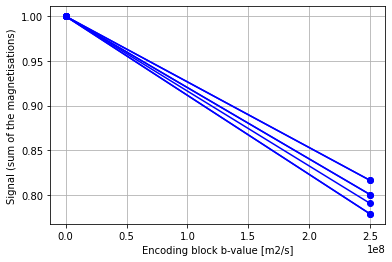

In [84]:
# example code for Gabe
# E Powell, 24/11/2023

bf = np.array([0, 0, 250, 250, 250, 250, 250, 250]) * 1e6    
# filter b-values [s/m2]
#bf = bf.reshape(-1, 1)  # probs not needed because 1d - Reshaping to a column vector
be = np.array([0, 250, 0, 250, 0, 250, 0, 250]) * 1e6         
# encoding b-values [s/m2]
tm = np.array([20, 20, 20, 20, 200, 200, 400, 400]) * 1e-3    
# mixing time [s]

sim_adc = 1e-9                             # ADC, simulated [m2/s]
sim_sig = 0.2                              # sigma, simulated [a.u.]
sim_axr = 3                                # AXR, simulated [s-1]

# simulate signals
s = np.array(axr_sim(sim_adc, sim_sig, sim_axr, bf, be, tm))

# fit model to simulated signals and estimate parameters
init = np.array([1.1e-9, .15, 3.5])
lb = np.array([.1e-9, 0, .1])
ub = np.array([3.5e-9, 1, 20])



for i in range(be.shape[0] - 1):
    plt.plot([be[i], be[i + 1]], [s[i], s[i + 1]], 'bo-')

#plt.title('Scatter plot with 4 lines')
plt.xlabel('Encoding block b-value [m2/s]')
#are units correct
plt.ylabel('Normalised? Signal (sum of the magnetisations)')
#unit?
plt.grid(True)
plt.show()

# fit_adc, fit_sig, fit_axr = axr_fit(bf, be, tm, s, init, lb, ub)

In [ ]:
# print and compare simulated vs fitted
[sim_adc, sim_sig, sim_axr].*[1e9 1 1]
[fit_adc, fit_sig, fit_axr].*[1e9 1 1]

SyntaxError: invalid syntax (2671205147.py, line 2)

### My old method

Say we wanted to calculate s for a random distribution of adc values.
I think axr may also vary, but both are probs linked to each other. 

In [ ]:

#adc=1
sigma=2
axr=3

be = np.array([np.repeat(0,10), np.repeat(250,10)]).flatten()
bf = np.array([1e-6, 0.090, 1e-6, 0, 1e-6, 1.5, 1e-6, 2, 1e-6, 3,1e-6, 0, 1e-6, 0.500, 1e-6, 1.5, 1e-6, 2, 1e-6, 3])
tm = np.array([1e-6, 0.090, 1e-6, -1, 1e-6, 1.5, 1e-6, 2, 1e-6, 3,1e-6, 0.090, 1e-6, 0.500, 1e-6, 1.5, 1e-6, 2, 1e-6, 3])
nvox = 1000

#axrs = np.random.uniform(1,100,nvox) 
adcs = np.random.uniform(200,300,nvox) 

#axr_sim(adc,sigma,axr,bf,be,tm)


s = np.array([axr_sim(adc,sigma,axr,bf,be,tm) for adc in adcs]) 
